# Human Activity Data on Kaggle

https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones

The Human Activity Recognition database was built from the recordings of 30 study participants (19 - 48 years old) performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors. The objective is to classify activities into one of the six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) performed.

They were wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. 

For each record in the dataset the following is provided:

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
- Triaxial Angular velocity from the gyroscope.
- A 561-feature vector with time and frequency domain variables.
- Its activity label.
- An identifier of the subject who carried out the experiment.

### Notes: 

- Features are normalized and bounded within [-1,1].
- Each feature vector is a row on the text file.
- The units used for the accelerations (total and body) are 'g's (gravity of earth -> 9.80665 m/seg2).
- The gyroscope units are rad/seg.
- A video of the experiment including an example of the 6 recorded activities with one of the participants can be seen in the following link: http://www.youtube.com/watch?v=XOEN9W05_4A


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

% matplotlib inline


## Load Data

In [2]:
path = "./human-activity-recognition-with-smartphones/"
train_filename = "train.csv"
test_filename = "test.csv"
train = pd.read_csv(path+train_filename)
test = pd.read_csv(path+test_filename)

In [6]:
# Merge current train and test
df_all = train.append(test)

In [7]:
df_all.shape

(10299, 563)

In [13]:
df_all['subject'].unique()

array([ 1,  3,  5,  6,  7,  8, 11, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26,
       27, 28, 29, 30,  2,  4,  9, 10, 12, 13, 18, 20, 24])

In [75]:
activity = df_all.Activity.unique().tolist()

In [27]:
# Split into different subjects and store in 30 different dataframes
# sub1, sub2, ..., sub30
columns = df_all.columns.tolist()
df_list = []
train_moving = pd.DataFrame(columns = columns)
train_sedentary = pd.DataFrame(columns = columns)
test_moving = pd.DataFrame(columns = columns)
test_sedentary = pd.DataFrame(columns = columns)

for i in range(1, 31):
    df_tmp = df_all[df_all.subject == i]
    name = "sub" + str(i)
    df_list.append(name)
    exec(name + " = pd.DataFrame(columns = columns)")
    exec(name + " = " + name + ".append(df_all[df_all.subject == i])")

Let's just take a look at some sample data for one subject.

In [ ]:
colors = ['']

In [ ]:
import seaborn as sns
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

index = sub1.index.values
sns.pointplot(x = index, y = "tBodyAcc-mean()-X", hue = "Activity", data=sub1, palette = sns.cubehelix_palette(8))
sns.pointplot(x = index , y = "tBodyAcc-mean()-Y", hue = "Activity", data = sub1, palette = sns.color_palette("Blues"))
fig.savefig("sub1.png")

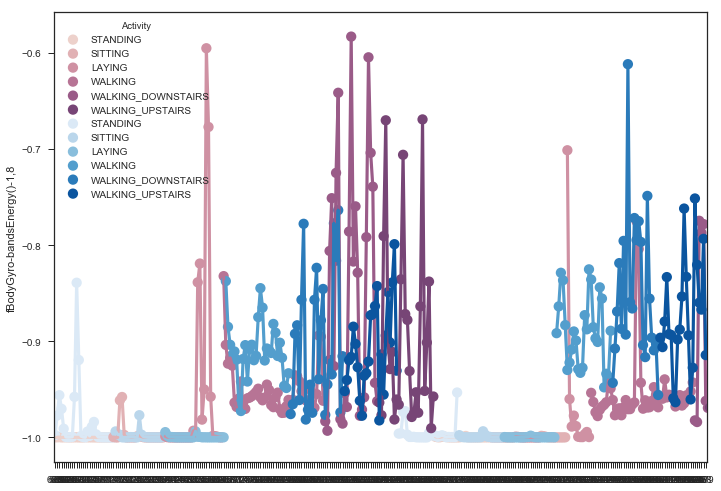

In [141]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

index1 = sub1.index.values
index5 = sub5.index.values
sns.pointplot(x = index1, y = "fBodyGyro-bandsEnergy()-1,8", hue = "Activity", data=sub1)
sns.pointplot(x = index5, y = "fBodyGyro-bandsEnergy()-1,8", hue = "Activity", data=sub5, palette = sns.color_palette("Blues"))

In [ ]:
tGravityAccMag-max()

In [63]:
# Split each dataframe into moving and sedentary
def split_moving_sedentary(df):
    sedentary_ind = [i for i, a in enumerate(df.Activity) if a == 'LAYING' or a == 'STANDING' or a == 'SITTING']
    moving_ind =  [i for i, a in enumerate(df.Activity) if a == 'WALKING' or a == 'WALKING_UPSTAIRS' or a == 'WALKING_DOWNSTAIRS']
    sedentary = df.iloc[sedentary_ind, :]
    moving = df.iloc[moving_ind, :]
    return sedentary, moving    

In [121]:
# Split into different subjects and store in 30 different dataframes
# sub1, sub2, ..., sub30
columns = df_all.columns.tolist()
df_list = []
train_moving = pd.DataFrame(columns = columns)
train_sedentary = pd.DataFrame(columns = columns)
test_moving = pd.DataFrame(columns = columns)
test_sedentary = pd.DataFrame(columns = columns)

for i in range(1, 31):
    df_tmp = df_all[df_all.subject == i]
    sed, mov = split_moving_sedentary(df_tmp)
    # Divide the data into 80% training & 20% development set
    sed_split_point = int(sed.shape[0] * 0.8)
    train_sed, test_sed = sed[:sed_split_point], sed[sed_split_point:]
    train_sedentary = train_sedentary.append(train_sed)
    test_sedentary = test_sedentary.append(test_sed)
    mov_split_point = int(mov.shape[0] * 0.8)
    train_mov, test_mov = mov[:mov_split_point], mov[mov_split_point:]
    train_moving = train_moving.append(train_mov)
    test_moving = test_moving.append(test_mov)

In [123]:
# Size of Datasets
train_sedentary.shape, test_sedentary.shape, train_moving.shape, test_moving.shape

((4491, 563), (1136, 563), (3726, 563), (946, 563))

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

index = train_moving.index.values
sns.pointplot(x = index, y = "tBodyAcc-mean()-X", hue = "Activity", data=train_moving[:100,], palette = sns.cubehelix_palette(8))
sns.pointplot(x = index , y = "tBodyAcc-mean()-Y", hue = "Activity", data = train_moving[:100,], palette = sns.color_palette("Blues"))
fig.savefig("train_moving.png")

## Feature Selection - Manual 

1. Only use FFT features from accelerometer without jerk features and magnitude data

In [149]:
fft_acc_features = [x for x in df_all.columns.tolist() if x.startswith("f") and \
                "gyro" not in x.lower() and "jerk" not in x.lower() and "mag" not in x.lower()]

In [157]:
len(fft_acc_features)

79

In [150]:
# Filter  
train_moving_fft_acc = train_moving[fft_acc_features]
train_sedentary_fft_acc = train_sedentary[fft_acc_features]
test_moving_fft_acc = test_moving[fft_acc_features]
test_sedentary_fft_acc = test_sedentary[fft_acc_features]

In [151]:
train_moving_fft_acc.shape, train_sedentary_fft_acc.shape, test_moving_fft_acc.shape, test_sedentary_fft_acc.shape

((3726, 79), (4491, 79), (946, 79), (1136, 79))

1. 
2. Only use FFT features from gyroscope without jerk features and magnitude data

In [152]:
fft_gyro_features = [x for x in df_all.columns.tolist() if x.startswith("f") and \
                "acc" not in x.lower() and "jerk" not in x.lower() and "mag" not in x.lower()]

In [156]:
len(fft_gyro_features)

79

In [153]:
# Filter  
train_moving_fft_gyro = train_moving[fft_gyro_features]
train_sedentary_fft_gyro = train_sedentary[fft_gyro_features]
test_moving_fft_gyro = test_moving[fft_gyro_features]
test_sedentary_fft_gyro = test_sedentary[fft_gyro_features]

In [160]:
train_moving_fft_gyro.shape, train_sedentary_fft_gyro.shape, test_moving_fft_gyro.shape, test_sedentary_fft_gyro.shape

((3726, 79), (4491, 79), (946, 79), (1136, 79))

1. 
2. 
3. Only use jerk features for accelerometer data

In [171]:
jerk_acc_features = [x for x in df_all.columns.tolist() if "jerk" in x.lower() and "acc" in x.lower()]

In [172]:
len(jerk_acc_features)

146

In [196]:
# Filter  
train_moving_jerk_acc = train_moving[jerk_acc_features]
train_sedentary_jerk_acc = train_sedentary[jerk_acc_features]
test_moving_jerk_acc = test_moving[jerk_acc_features]
test_sedentary_jerk_acc = test_sedentary[jerk_acc_features]

In [197]:
train_moving_jerk_acc.shape

(3726, 146)

1. 
2. 
3. 
4. Only use jerk features for gyroscope data

In [173]:
jerk_gyro_features = [x for x in df_all.columns.tolist() if "jerk" in x.lower() and "gyro" in x.lower()]

In [174]:
len(jerk_gyro_features)

67

In [198]:
# Filter  
train_moving_jerk_gyro = train_moving[jerk_gyro_features]
train_sedentary_jerk_gyro = train_sedentary[jerk_gyro_features]
test_moving_jerk_gyro = test_moving[jerk_gyro_features]
test_sedentary_jerk_gyro = test_sedentary[jerk_gyro_features]

### Separate The Labels from the Attributes

In [260]:
train_moving_y = train_moving['subject'].astype(str)
# test = train_moving['Activity']
test_moving_y = test_moving['subject'].astype(str)
train_sedentary_y = train_sedentary['subject'].astype(str)
test_sedentary_y = test_sedentary['subject'].astype(str)

## Feature Selection - Algorithm

1. PCA


In [234]:
from sklearn.decomposition import PCA

# For moving data
pca = PCA(n_components=100, svd_solver='full')
train_moving_pca = pca.fit_transform(train_moving.iloc[:, :-2])  
test_moving_pca = pca.transform(test_moving.iloc[:, :-2])  

# For sedentary data
pca = PCA(n_components=100, svd_solver='full')
train_sedentary_pca = pca.fit_transform(train_sedentary.iloc[:, :-2])  
test_sedentary_pca = pca.transform(test_sedentary.iloc[:, :-2])  

1. 
2. LinearSVC

In [265]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train_moving.iloc[:, :-2], train_moving_y)
lsvc = SelectFromModel(lsvc, prefit=True)
train_moving_svc = lsvc.transform(train_moving.iloc[:, :-2])
test_moving_svc = lsvc.transform(test_moving.iloc[:, :-2])
train_moving_svc.shape, test_moving_svc.shape

((3726, 131), (946, 131))

In [266]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train_sedentary.iloc[:, :-2], train_sedentary_y)
lsvc = SelectFromModel(lsvc, prefit=True)
train_sedentary_svc = lsvc.transform(train_sedentary.iloc[:, :-2])
test_sedentary_svc = lsvc.transform(test_sedentary.iloc[:, :-2])
train_sedentary_svc.shape, test_sedentary_svc.shape

((4491, 164), (1136, 164))

## Modeling

In [175]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

Classifiers = [linear_model.LogisticRegression(multi_class="ovr"),
               DecisionTreeClassifier(), 
               RandomForestClassifier(n_estimators=200),
               GaussianNB(), 
               svm.SVC()]

In [363]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from time import time

def train_clf(X_train, y_train, X_test, y_test):
    accuracy = []
    train_time = []
    pred_time = []
    cnf_matrix = {}
    for clf in Classifiers:
        start = time()
        fit=clf.fit(X_train, y_train)
        end = time()
        train_time.append(end - start)
        start = time()
        pred = fit.predict(X_test)
        end = time()
        pred_time.append(end - start)
        accuracy.append(accuracy_score(y_test, pred))
        cnf_matrix[clf.__class__.__name__] = confusion_matrix(y_test, pred)
        print "finished training for " + clf.__class__.__name__
    print "finished for all models"
    print "============================================"
    return({"accuracy": accuracy, "cnf_matrix": cnf_matrix, "train_time": train_time, "pred_time": pred_time})

### - Moving Data

In [364]:
input_selected = {"fft_acc": (train_moving_fft_acc, train_moving_y, test_moving_fft_acc, test_moving_y), \
                  "fft_gyro": (train_moving_fft_gyro, train_moving_y, test_moving_fft_gyro, test_moving_y), \
                  "jerk_acc": (train_moving_jerk_acc, train_moving_y, test_moving_jerk_acc, test_moving_y), \
                  "jerk_gyro": (train_moving_jerk_gyro, train_moving_y, test_moving_jerk_gyro, test_moving_y), \
                  "pca": (train_moving_pca, train_moving_y, test_moving_pca, test_moving_y), \
                  "svc": (train_moving_svc, train_moving_y, test_moving_svc, test_moving_y)
                  }

In [365]:
labels = list(input_selected.keys())
labels

['jerk_gyro', 'svc', 'fft_acc', 'fft_gyro', 'pca', 'jerk_acc']

In [366]:
# Train all the models for different feature sets
# Results saved in a dictionary called res
res_mov = {}
for key, value in input_selected.iteritems():
    res_mov[key] = train_clf(value[0], value[1], value[2], value[3])

finished training for LogisticRegression
finished training for DecisionTreeClassifier
finished training for RandomForestClassifier
finished training for GaussianNB
finished training for SVC
finished for all models
finished training for LogisticRegression
finished training for DecisionTreeClassifier
finished training for RandomForestClassifier
finished training for GaussianNB
finished training for SVC
finished for all models
finished training for LogisticRegression
finished training for DecisionTreeClassifier
finished training for RandomForestClassifier
finished training for GaussianNB
finished training for SVC
finished for all models
finished training for LogisticRegression
finished training for DecisionTreeClassifier
finished training for RandomForestClassifier
finished training for GaussianNB
finished training for SVC
finished for all models
finished training for LogisticRegression
finished training for DecisionTreeClassifier
finished training for RandomForestClassifier
finished trai

In [367]:
# Give shorter name for plotting 
model = ['LR', 'DT', 'RF', 'GNB', 'SVM']

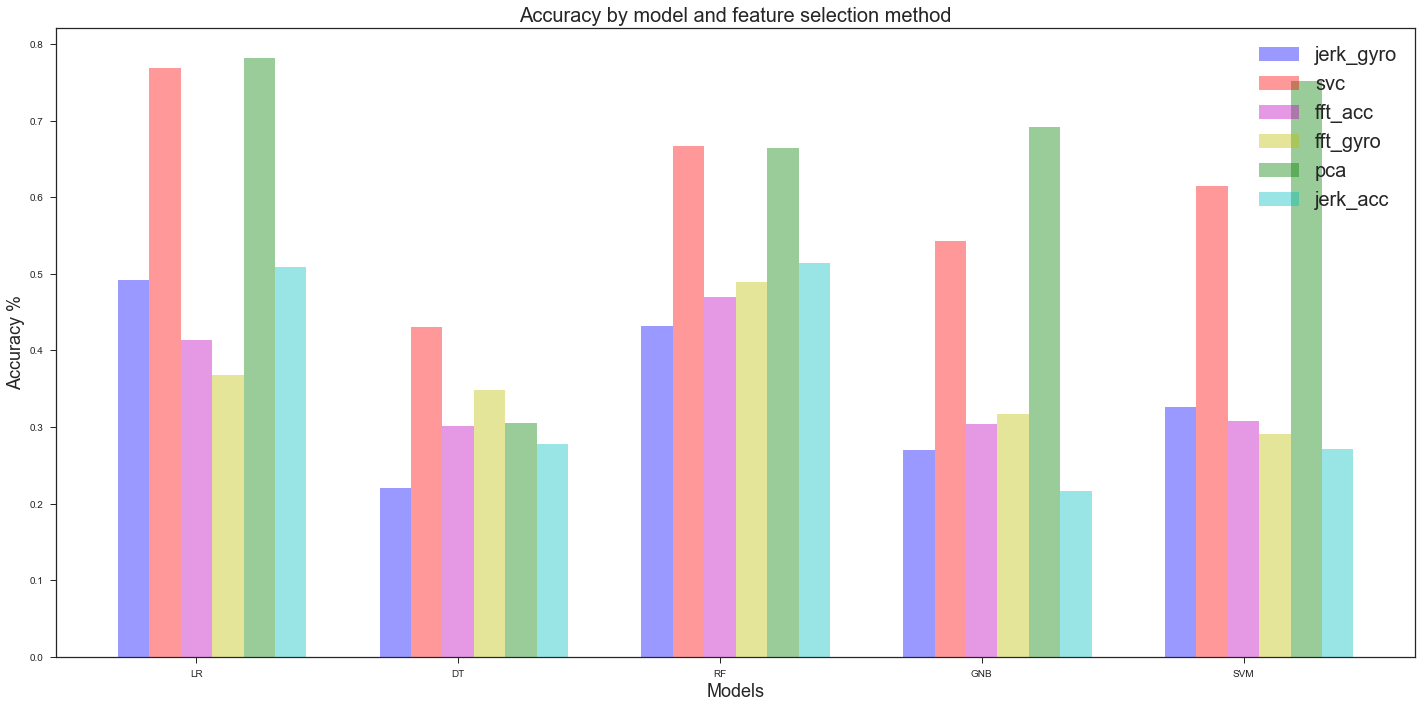

In [368]:
# Plot the accuracy for each input feature set and each classifier
plt.figure(figsize=(20,10))

index = np.arange(len(model))
bar_width = 0.12
opacity = 0.4
error_config = {'ecolor': '0.3'}

i = 0
colors = ['b', 'r', 'm', 'y', 'g', 'c']
for key, value in res.iteritems():
    plt.bar(index + i*bar_width, res_mov[key]['accuracy'], bar_width,
                 alpha = opacity,
                 color = colors[i],
                 error_kw = error_config,
                 label = labels[i])
    i += 1

plt.xlabel('Models', fontsize=18)
plt.ylabel('Accuracy %', fontsize = 18)
plt.title('Accuracy by model and feature selection method', fontsize = 20)
plt.xticks(index + bar_width*2, ('LR', 'DT', 'RF', 'GNB', 'SVM'))
plt.legend(fontsize=20)

plt.tight_layout()

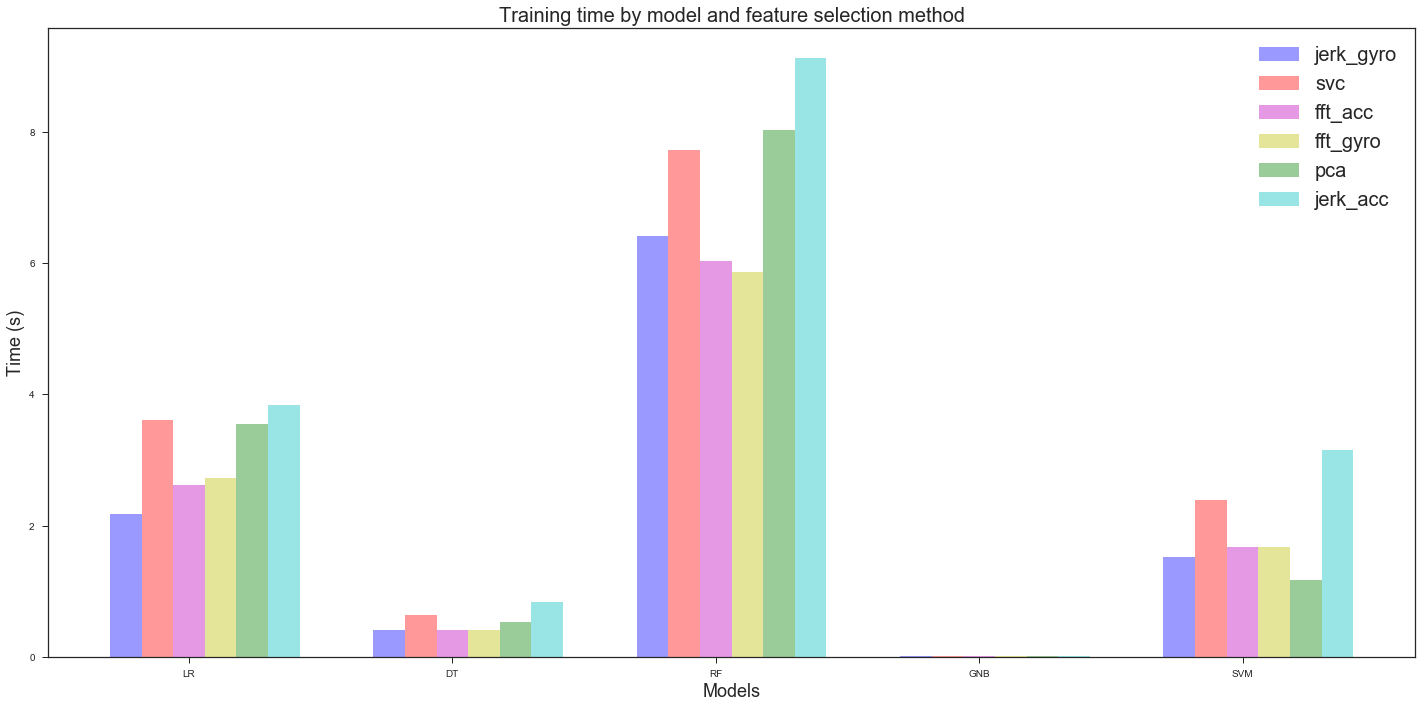

In [369]:
# Plot the training time for each input feature set and each classifier
plt.figure(figsize=(20,10))

index = np.arange(len(model))
bar_width = 0.12
opacity = 0.4
error_config = {'ecolor': '0.3'}

i = 0
colors = ['b', 'r', 'm', 'y', 'g', 'c']
for key, value in res.iteritems():
    plt.bar(index + i*bar_width, res_mov[key]['train_time'], bar_width,
                 alpha = opacity,
                 color = colors[i],
                 error_kw = error_config,
                 label = labels[i])
    i += 1

plt.xlabel('Models', fontsize = 18)
plt.ylabel('Time (s)', fontsize = 18)
plt.title('Training time by model and feature selection method', fontsize = 20)
plt.xticks(index + bar_width*2, ('LR', 'DT', 'RF', 'GNB', 'SVM'))
plt.legend(fontsize=20)

plt.tight_layout()

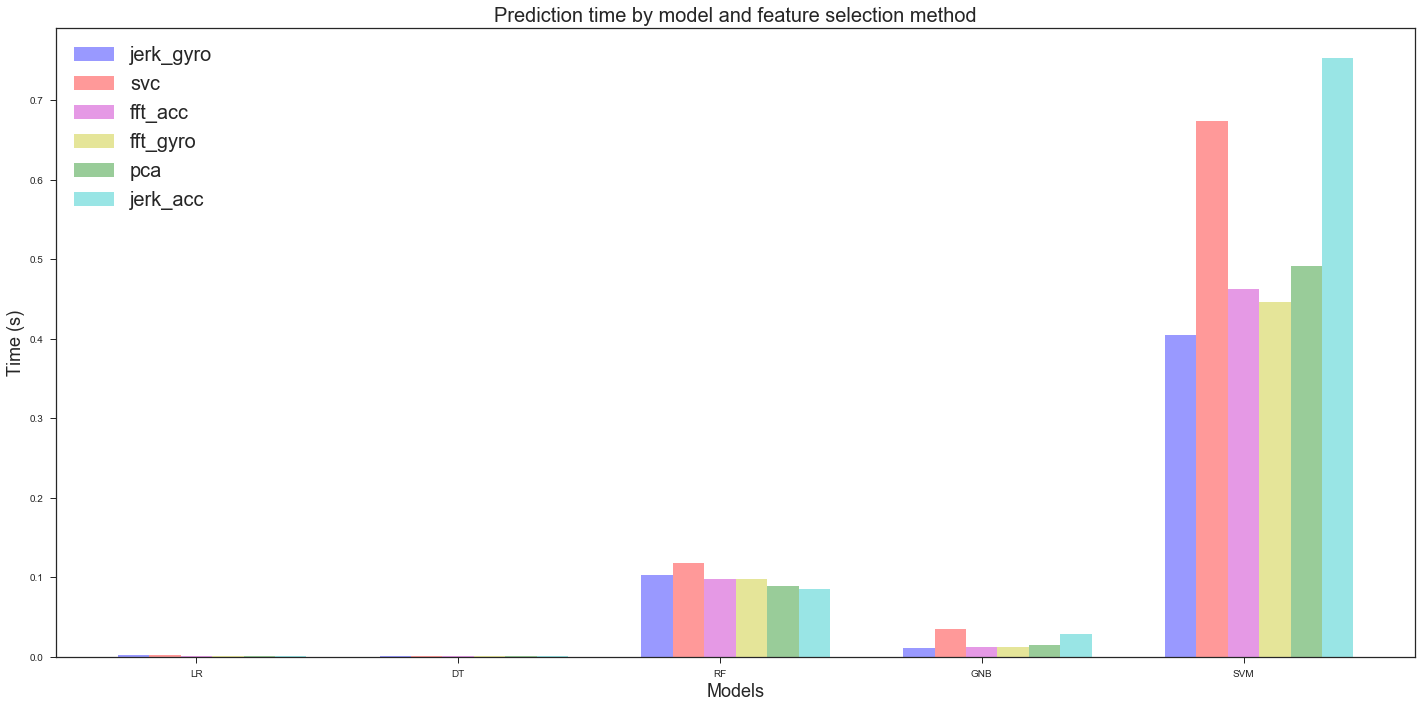

In [370]:
# Plot the prediction time for each input feature set and each classifier
plt.figure(figsize=(20,10))

index = np.arange(len(model))
bar_width = 0.12
opacity = 0.4
error_config = {'ecolor': '0.3'}

i = 0
colors = ['b', 'r', 'm', 'y', 'g', 'c']
for key, value in res.iteritems():
    plt.bar(index + i*bar_width, res_mov[key]['pred_time'], bar_width,
                 alpha = opacity,
                 color = colors[i],
                 error_kw = error_config,
                 label = labels[i])
    i += 1

plt.xlabel('Models', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)
plt.title('Prediction time by model and feature selection method', fontsize=20)
plt.xticks(index + bar_width*2, ('LR', 'DT', 'RF', 'GNB', 'SVM'))
plt.legend(fontsize=20)

plt.tight_layout()

### - Sedentary Data

In [388]:
input_selected = {"fft_acc": (train_sedentary_fft_acc, train_sedentary_y, test_sedentary_fft_acc, test_sedentary_y), \
                  "fft_gyro": (train_sedentary_fft_gyro, train_sedentary_y, test_sedentary_fft_gyro, test_sedentary_y), \
                  "jerk_acc": (train_sedentary_jerk_acc, train_sedentary_y, test_sedentary_jerk_acc, test_sedentary_y), \
                  "jerk_gyro": (train_sedentary_jerk_gyro, train_sedentary_y, test_sedentary_jerk_gyro, test_sedentary_y), \
                  "pca": (train_sedentary_pca, train_sedentary_y, test_sedentary_pca, test_sedentary_y), \
                  "svc": (train_sedentary_svc, train_sedentary_y, test_sedentary_svc, test_sedentary_y)
                  }

In [389]:
# Train all the models for different feature sets
# Results saved in a dictionary called res_sed
res_sed = {}
for key, value in input_selected.iteritems():
    res_sed[key] = train_clf(value[0], value[1], value[2], value[3])

finished training for LogisticRegression
finished training for DecisionTreeClassifier
finished training for RandomForestClassifier
finished training for GaussianNB
finished training for SVC
finished for all models
finished training for LogisticRegression
finished training for DecisionTreeClassifier
finished training for RandomForestClassifier
finished training for GaussianNB
finished training for SVC
finished for all models
finished training for LogisticRegression
finished training for DecisionTreeClassifier
finished training for RandomForestClassifier
finished training for GaussianNB
finished training for SVC
finished for all models
finished training for LogisticRegression
finished training for DecisionTreeClassifier
finished training for RandomForestClassifier
finished training for GaussianNB
finished training for SVC
finished for all models
finished training for LogisticRegression
finished training for DecisionTreeClassifier
finished training for RandomForestClassifier
finished trai

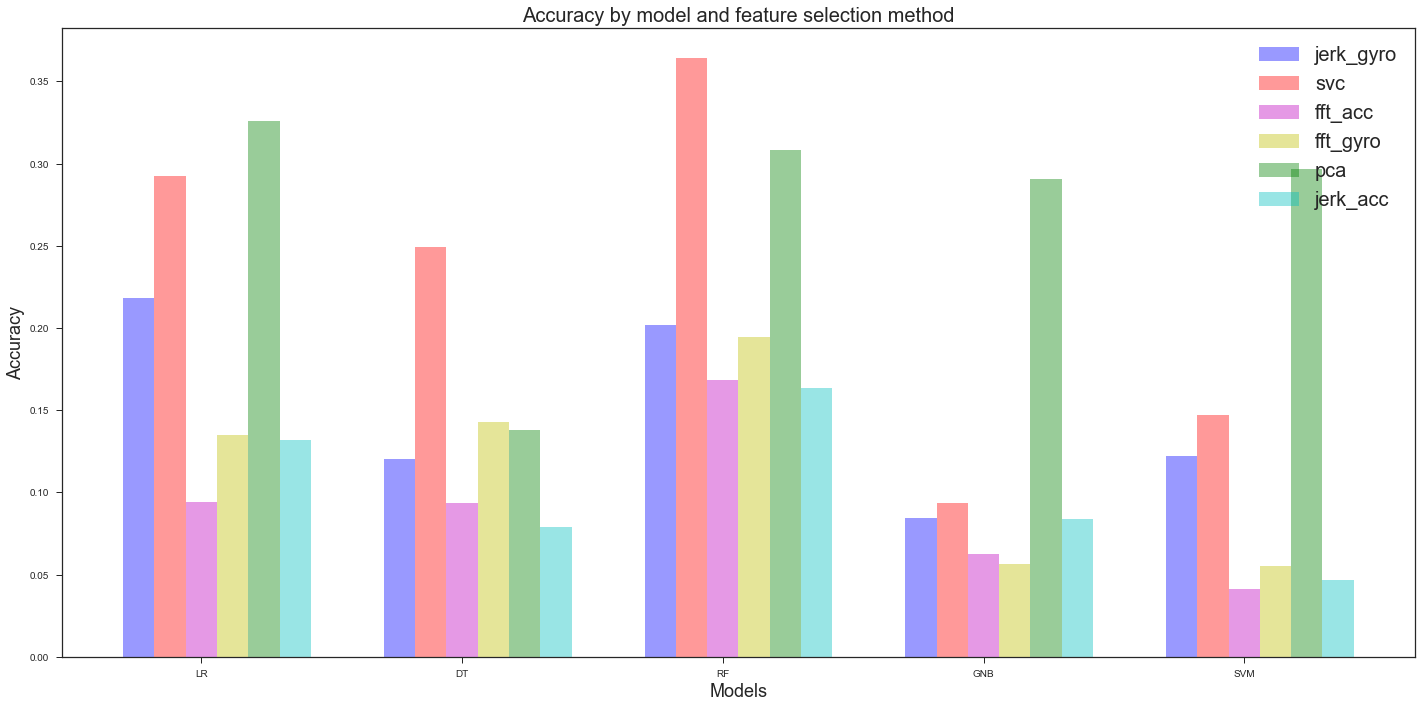

In [390]:
# Plot the accuracy for each input feature set and each classifier
plt.figure(figsize=(20,10))

index = np.arange(len(model))
bar_width = 0.12
opacity = 0.4
error_config = {'ecolor': '0.3'}

i = 0
colors = ['b', 'r', 'm', 'y', 'g', 'c']
for key, value in res.iteritems():
    plt.bar(index + i*bar_width, res_sed[key]['accuracy'], bar_width,
                 alpha = opacity,
                 color = colors[i],
                 error_kw = error_config,
                 label = labels[i])
    i += 1

plt.xlabel('Models', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.title('Accuracy by model and feature selection method', fontsize=20)
plt.xticks(index + bar_width*2, ('LR', 'DT', 'RF', 'GNB', 'SVM'))
plt.legend(fontsize=20)

plt.tight_layout()

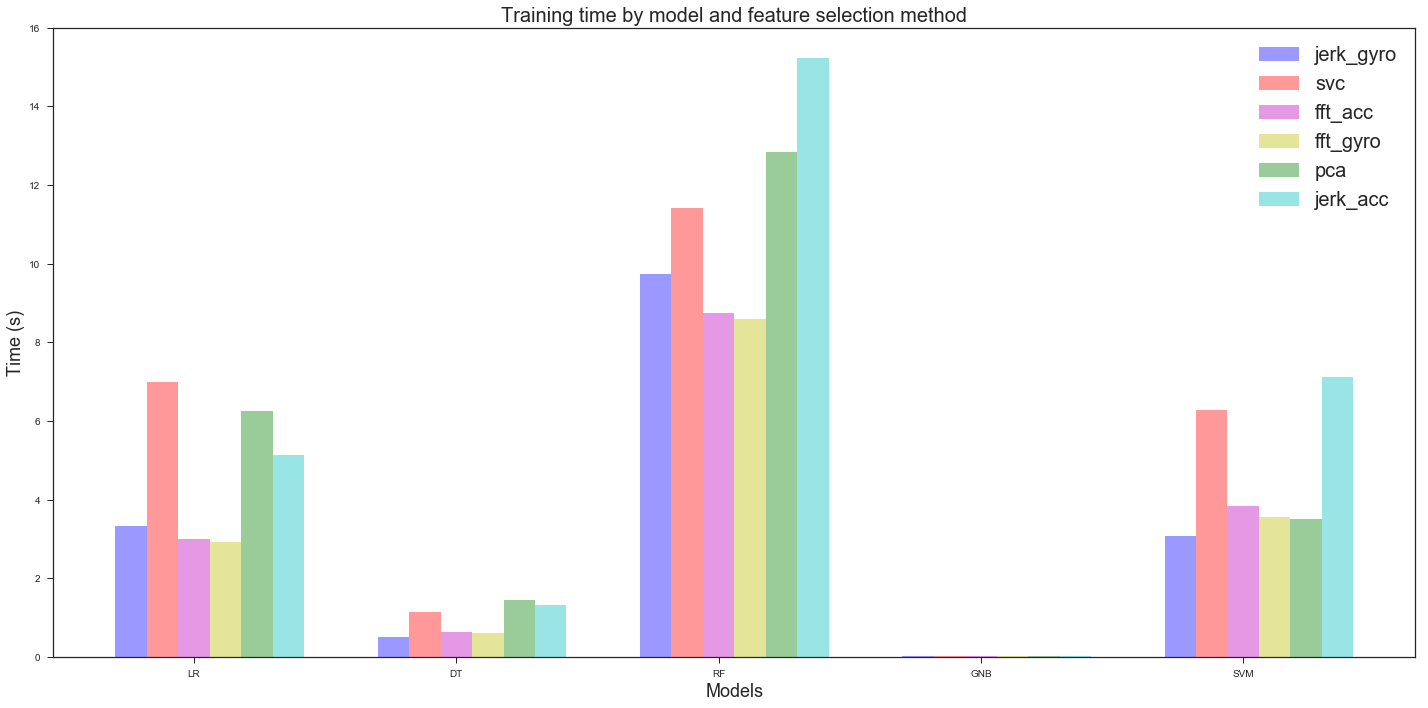

In [391]:
# Plot the training time for each input feature set and each classifier
plt.figure(figsize=(20,10))

index = np.arange(len(model))
bar_width = 0.12
opacity = 0.4
error_config = {'ecolor': '0.3'}

i = 0
colors = ['b', 'r', 'm', 'y', 'g', 'c']
for key, value in res.iteritems():
    plt.bar(index + i*bar_width, res_sed[key]['train_time'], bar_width,
                 alpha = opacity,
                 color = colors[i],
                 error_kw = error_config,
                 label = labels[i])
    i += 1

plt.xlabel('Models', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)
plt.title('Training time by model and feature selection method', fontsize=20)
plt.xticks(index + bar_width*2, ('LR', 'DT', 'RF', 'GNB', 'SVM'))
plt.legend(fontsize=20)

plt.tight_layout()

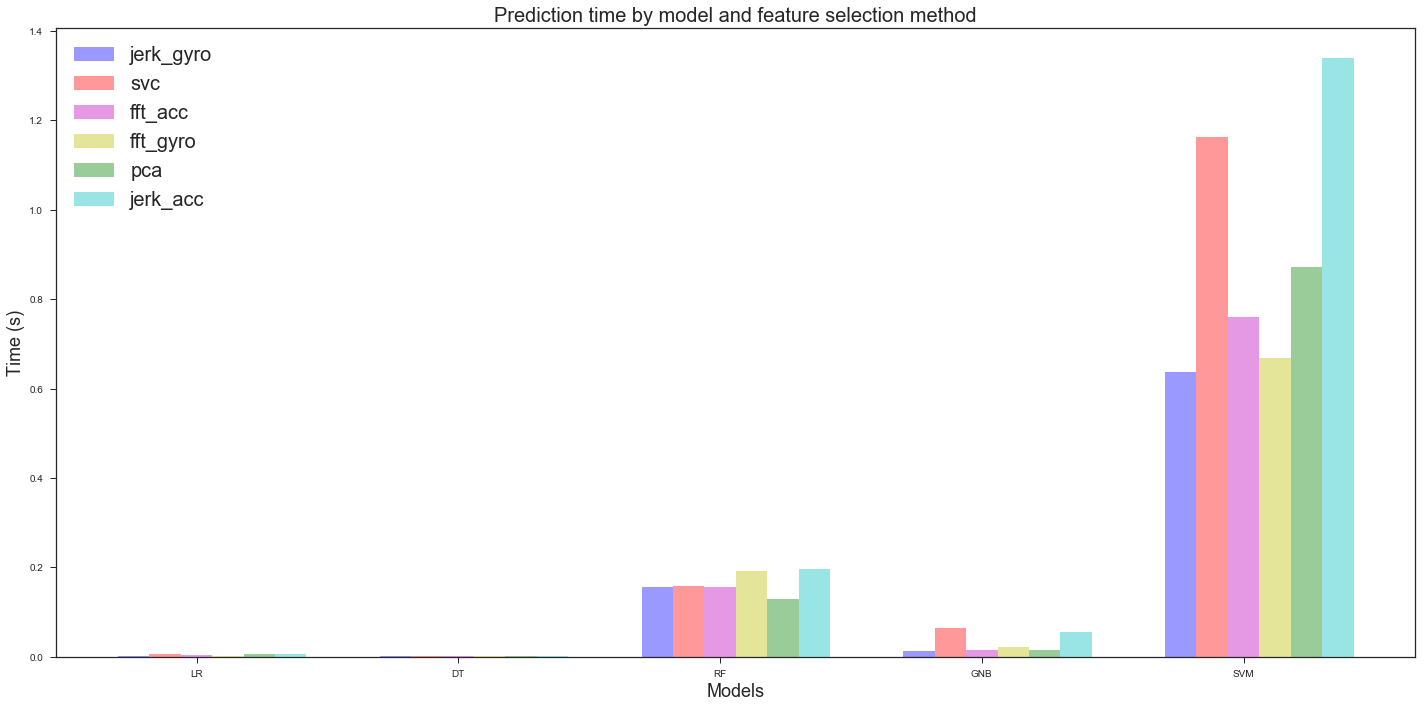

In [392]:
# Plot the prediction time for each input feature set and each classifier
plt.figure(figsize=(20,10))

index = np.arange(len(model))
bar_width = 0.12
opacity = 0.4
error_config = {'ecolor': '0.3'}

i = 0
colors = ['b', 'r', 'm', 'y', 'g', 'c']
for key, value in res.iteritems():
    plt.bar(index + i*bar_width, res_sed[key]['pred_time'], bar_width,
                 alpha = opacity,
                 color = colors[i],
                 error_kw = error_config,
                 label = labels[i])
    i += 1

plt.xlabel('Models', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)
plt.title('Prediction time by model and feature selection method', fontsize=20)
plt.xticks(index + bar_width*2, ('LR', 'DT', 'RF', 'GNB', 'SVM'))
plt.legend(fontsize=20)

plt.tight_layout()

## Classify if someone is moving/sedentary first -> predict the subject

## Evaluation - Confusion Matrix

### Moving Data

In [383]:
# The confusion matrix for Random Forest with SVC
cnf_matrix = res_mov['svc']['cnf_matrix']['LogisticRegression']
cnf_matrix2 = res_mov['pca']['cnf_matrix']['LogisticRegression']

In [375]:
cnf_matrix.shape

(30, 30)

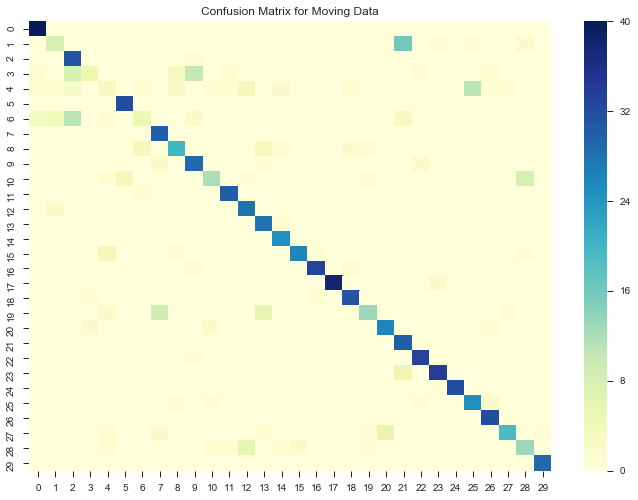

In [384]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(cnf_matrix2, cmap="YlGnBu")
ax.set_title('Confusion Matrix for Moving Data')

In [377]:
np.trace(cnf_matrix)

727

In [386]:
new_cnf_matrix2 = np.matrix(cnf_matrix2)

In [385]:
def cnf_matrix_metrics(cnf_matrix):
    above = 0
    below = 0
    trace = 0
    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            if (i < j):
                above += cnf_matrix[i, j]
            elif (i > j):
                below += cnf_matrix[i, j]
            else: 
                trace += cnf_matrix[i, j]
    return(above, below, trace)

In [387]:
print cnf_matrix_metrics(new_cnf_matrix2)

(98, 108, 740)


### - Sedentary Data

In [401]:
# The confusion matrix for Random Forest with SVC
sed_cnf_matrix = res_sed['svc']['cnf_matrix']


dict

In [405]:
cnf_matrix_compare = {}
for key, value in sed_cnf_matrix.iteritems():
    cnf_matrix_compare[key] = cnf_matrix_metrics(np.matrix(value))

In [406]:
cnf_matrix_compare

{'DecisionTreeClassifier': (475, 378, 283),
 'GaussianNB': (575, 455, 106),
 'LogisticRegression': (427, 377, 332),
 'RandomForestClassifier': (383, 339, 414),
 'SVC': (465, 504, 167)}

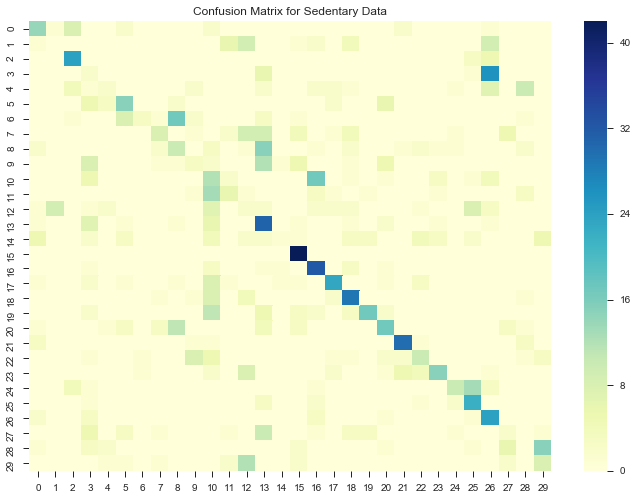

In [397]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(cnf_matrix, cmap="YlGnBu")
ax.set_title('Confusion Matrix for Sedentary Data')

In [398]:
for 
cnf_matrix_metrics(new_cnf_matrix)

(94, 125, 727)